In [1]:
# 

In [2]:
#models
import numpy as np

from keras.layers import Embedding, Reshape,Concatenate, dot, Dropout, Dense,Input,Flatten,merge,concatenate
from keras import Model
from keras.models import Sequential
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras import backend as K

def Collaborative_FilteringModel(n_users,n_items ,emb_dim):
        user_input = Input(shape=[1])
        item_input = Input(shape=[1])
        user_embedding = Embedding(output_dim=emb_dim, input_dim=n_users + 1,
                               input_length=1)(user_input)
        item_embedding = Embedding(output_dim=emb_dim, input_dim=n_items + 1,
                               input_length=1)(item_input)
        user_vecs = Flatten()(user_embedding)
        item_vecs = Flatten()(item_embedding)
        output = dot([user_vecs, item_vecs], axes=-1)
        model = Model(inputs=[user_input, item_input], outputs=output)
        return model

def Deep_networkModel(n_users,n_movies ,emb_dim):
    n_latent_factors_user = emb_dim
    n_latent_factors_movie = emb_dim

    movie_input = Input(shape=[1],name='Item')
    movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Embedding_for_movies')(movie_input)
    movie_vec = Flatten(name='Flatten_Movies')(movie_embedding)
    movie_vec = Dropout(0.2)(movie_vec)


    user_input = Input(shape=[1],name='User')
    user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors_user,name='Embedding_for_users')(user_input))
    user_vec = Dropout(0.2)(user_vec)
    concat =concatenate([movie_vec,user_vec],axis=-1, name='concat_')
#     import random
#     x = random.random()
#     x=x/3#----just to ensure dropout random is not too large
    concat = Dropout(0.2)(concat)
    dense = Dense(60,name='hiddenlayer1',activation='tanh')(concat)
    dropout_1 = Dropout(0.2,name='Dropout')(dense)
    dense_2 = Dense(30,name='hiddenlayer2',activation='tanh')(concat)
    dropout_2 = Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = Dense(15,name='hidden3',activation='tanh')(dense_2)
    dropout_3 = Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = Dense(15,name='hidden4', activation='tanh')(dense_3)


    result = Dense(1, activation='relu',name='result_node_with_relu_activation')(dense_4)

    model = Model([user_input, movie_input], result)

    return model





#trainig.................................................................................................

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# from CFModel import CFModel

RATINGS_CSV_FILE = 'ml1m_ratings.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_tanh.h5'
K_FACTORS = 60
RNG_SEED = 14465579


ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), ':number of ratings')


shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['user_emb_id'].values
print ('Users:', Users, ', shape =', Users.shape)
Movies = shuffled_ratings['movie_emb_id'].values
print ('Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['rating'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)

model =Deep_networkModel(max_userid, max_movieid, K_FACTORS)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(loss=root_mean_squared_error, optimizer='adamax')
batch_size=len(Ratings)
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model.fit([Users, Movies],Ratings, nb_epoch=30,  verbose=2, callbacks=callbacks,validation_split=.1)


loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.pow(loss,2)for loss in history.history['loss'] ],
                     'validation': [ math.pow(loss,2)for loss in history.history['val_loss'] ]})


min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss))


Using TensorFlow backend.


1000209 :number of ratings
Users: [5364 3398 5554 ... 5708  117 4670] , shape = (1000209,)
Movies: [1643  516 1516 ... 1126 3577 2099] , shape = (1000209,)
Ratings: [3 2 4 ... 5 5 4] , shape = (1000209,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


D:\anaconda\lib\site-packages\ipykernel_launcher.py:103: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Instructions for updating:
Use tf.cast instead.
Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 267s - loss: 0.9374 - val_loss: 0.9049
Epoch 2/30
 - 263s - loss: 0.8995 - val_loss: 0.8942
Epoch 3/30
 - 262s - loss: 0.8913 - val_loss: 0.8912
Epoch 4/30
 - 262s - loss: 0.8860 - val_loss: 0.8873
Epoch 5/30
 - 262s - loss: 0.8813 - val_loss: 0.8870
Epoch 6/30
 - 214s - loss: 0.8773 - val_loss: 0.8801
Epoch 7/30
 - 150s - loss: 0.8734 - val_loss: 0.8773
Epoch 8/30
 - 151s - loss: 0.8698 - val_loss: 0.8767
Epoch 9/30
 - 150s - loss: 0.8672 - val_loss: 0.8735
Epoch 10/30
 - 153s - loss: 0.8645 - val_loss: 0.8730
Epoch 11/30
 - 149s - loss: 0.8630 - val_loss: 0.8746
Epoch 12/30
 - 149s - loss: 0.8613 - val_loss: 0.8722
Epoch 13/30
 - 151s - loss: 0.8601 - val_loss: 0.8739
Epoch 14/30
 - 149s - loss: 0.8594 - val_loss: 0.8718
Epoch 15/30
 - 149s - loss: 0.8581 - val_loss: 0.8710
Epoch 16/30
 - 150s - loss: 0.8571 - val_loss: 0.8716
Epoch 17/30
 - 149s - loss: 0.8563 - val_loss

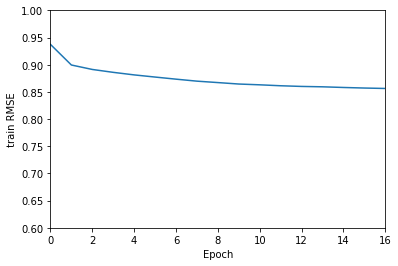

D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


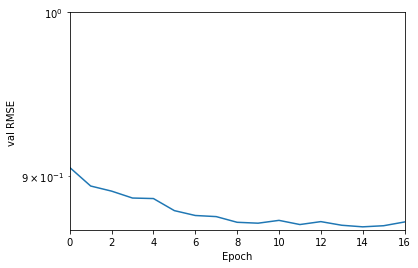

In [3]:
#plots..................................................................
pd.Series(history.history['loss']).plot(logy=False).set_ylim([0.6,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train RMSE ")
plt.show()
pd.Series(history.history['val_loss']).plot(logy=True).set_ylim([0.0,1.0])
plt.xlabel("Epoch")
plt.ylabel("val RMSE ")
plt.show()


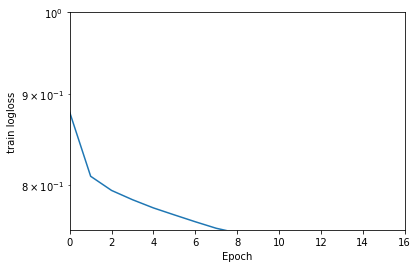

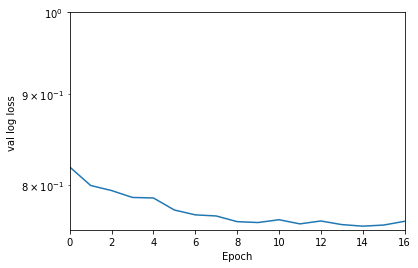

In [4]:
#plots..................................................................
pd.Series(loss['training']).plot(logy=True).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train logloss ")
plt.show()
pd.Series(loss['validation']).plot(logy=True).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel("val log loss ")
plt.show()



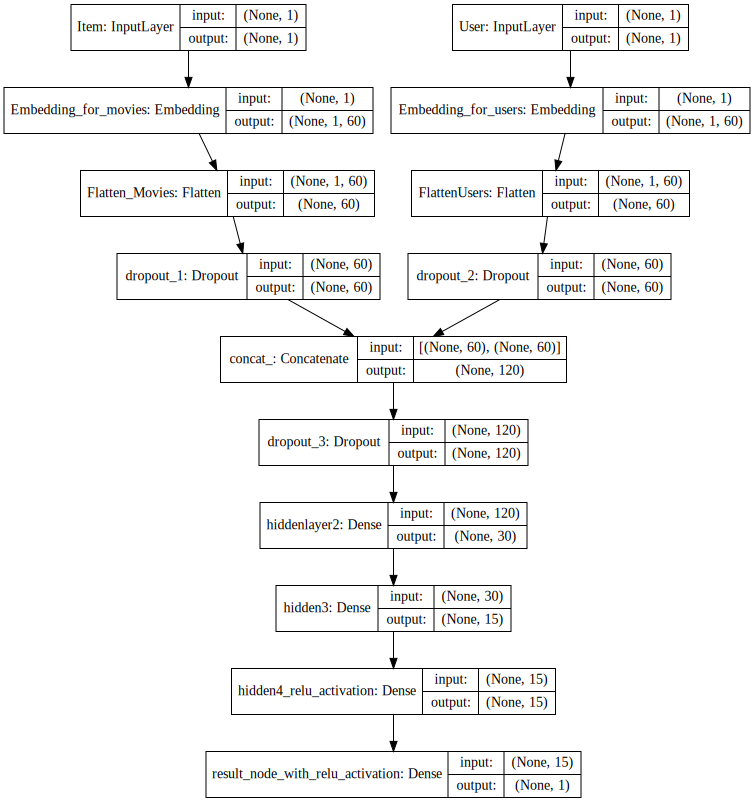

In [5]:
#architecture..................................................................
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [6]:
import pandas as pd
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_tanh.h5'
K_FACTORS = 60
TEST_USER = 234#<-test user.....
top_k_ratings=10

ratings = pd.read_csv(RATINGS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'movieid', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), 'ratings loaded.')

users = pd.read_csv(USERS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
print( len(users), 'descriptions of', max_userid, 'users loaded.')


movies = pd.read_csv(MOVIES_CSV_FILE, sep='\t', encoding='latin-1', usecols=['movieid', 'title', 'genre'])
print (len(movies), 'descriptions of', max_movieid, 'movies loaded.')

trained_model = Deep_networkModel(max_userid, max_movieid, K_FACTORS)

trained_model.load_weights(MODEL_WEIGHTS_FILE)
trained_model.summary()

users[users['userid'] == TEST_USER]
def predict_rating(userid, movieid):

      return trained_model.predict([np.array([userid]), np.array([movieid])])[0][0]

user_ratings = ratings[ratings['userid'] == TEST_USER][['userid', 'movieid', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movieid']), axis=1)

#Top K ratings for user..................................................................
user_ratings.sort_values(by='prediction', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings)

1000209 ratings loaded.
6040 descriptions of 6040 users loaded.
3883 descriptions of 3952 movies loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Embedding_for_movies (Embedding (None, 1, 60)        237180      Item[0][0]                       
__________________________________________________________________________________________________
Embedding_for_users (Embedding) (None, 1, 60)        362460      User[0][0]                       
____

,userid,movieid,rating,prediction,title,genre
0,234,1198,5,4.666378,Raiders of the Lost Ark (1981),Action|Adventure
1,234,1299,4,4.640384,"Killing Fields, The (1984)",Drama|War
2,234,1291,4,4.568472,Indiana Jones and the Last Crusade (1989),Action|Adventure
3,234,1293,5,4.522282,Gandhi (1982),Drama
4,234,1242,4,4.521364,Glory (1989),Action|Drama|War
5,234,1213,5,4.507247,GoodFellas (1990),Crime|Drama
6,234,1672,5,4.489521,"Rainmaker, The (1997)",Drama
7,234,2971,5,4.448093,All That Jazz (1979),Musical
8,234,1196,4,4.373606,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
9,234,1252,5,4.338604,Chinatown (1974),Film-Noir|Mystery|Thriller


In [7]:
user_ratings.sort_values(by='prediction', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings).to_csv("user_ratings_prediction_top_10.csv", 
              sep='\t', 
              header=True)